# Ensemble: sea ice trends

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import warnings
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })
warnings.filterwarnings('ignore')
xarray.set_options(keep_attrs=True);

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'Amon'
experiment = 'ssp585'
variable_id = 'pr'

spatial_text = 'precipitation (solid) net pr (dashed) over sea-ice and ocean'
spatial_units = 'mm day⁻¹' # base units kg m-2 s-1

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Precipitation ({time_series_units})'

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id,
    preprocess=conf['preprocess']
)

ensemble_time_series = libs.local.get_ensemble_series(variable_id, experiment)

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

In [4]:
conf_evspsbl = [v for v in libs.vars.variables() if v['variable_id'] == 'evspsbl'][0]
ensemble_evspsbl, weight_evspsbl = libs.ensemble.get_and_preprocess(
    'Amon', 
    experiment, 
    'evspsbl',
    preprocess=conf_evspsbl['preprocess']
)
ensemble_evspsbl_time_series = libs.local.get_ensemble_series('evspsbl', experiment)

data_vars = {}
for item in ensemble:
    item_mask = [item_mask for item_mask in ensemble_evspsbl if item_mask['label'] == item['label']]
    if len(item_mask) == 0:
        continue
        
    item_mask = item_mask[0]['data']
    processed_data = item['data']
    processed_data.attrs['color'] = item['color']
    processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')
    item_mask = item_mask.drop_vars(['height', 'type'], errors='ignore')

    item_weighted = (processed_data - item_mask).weighted(weight)
    item_reduced = getattr(
        item_weighted, 
        time_series_weighted_method
    )(dim=item_weighted.weights.dims, skipna=True)
    item_reduced.attrs['plot_kwargs'] = { 'linestyle': 'dashed' }
    
    data_vars[item['label']] = item_reduced

ds_prnet = xarray.Dataset(data_vars=data_vars)
ds_prnet = libs.ensemble.calc_variable_mean(ds_prnet)
ds_prnet['Ensemble mean'].attrs['plot_kwargs'] = { 'linestyle': 'dashed' }

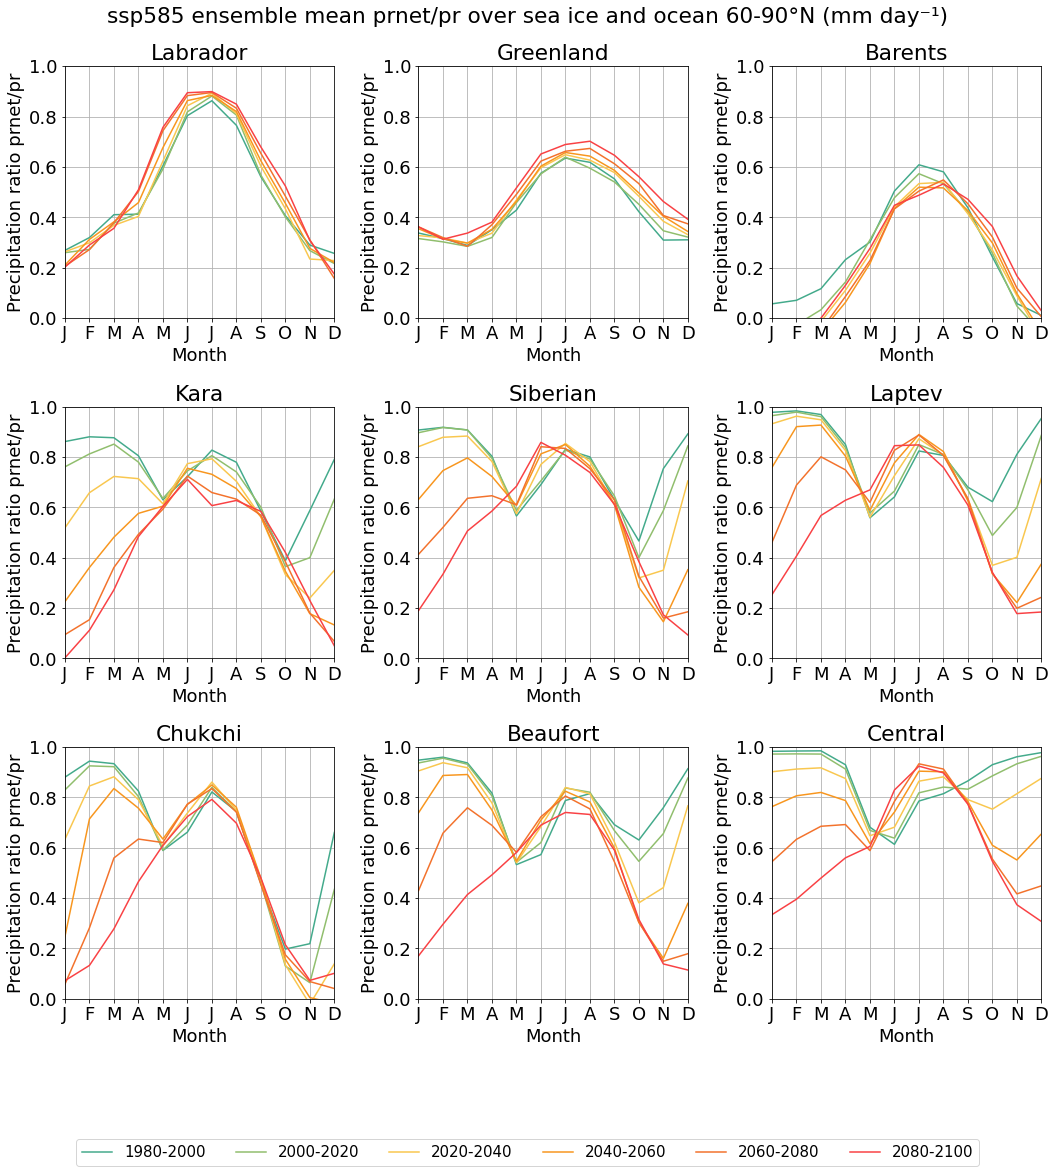

In [5]:
regions = libs.local.get_ensemble_regional_series('pr', experiment)
regions_prnet = libs.local.get_ensemble_regional_series('prnet', experiment)

# https://coolors.co/palette/f94144-f3722c-f8961e-f9c74f-90be6d-43aa8b-4d908e-277da1
time_slices_custom = [
    { 'slice': { 'time': slice('1980-01-01', '2001-01-01') }, 'label': '1980-2000', 'color': '#43aa8b' },
    { 'slice': { 'time': slice('2000-01-01', '2021-01-01') }, 'label': '2000-2020', 'color': '#90be6d' },
    { 'slice': { 'time': slice('2020-01-01', '2041-01-01') }, 'label': '2020-2040', 'color': '#f9c74f' },
    { 'slice': { 'time': slice('2040-01-01', '2061-01-01') }, 'label': '2040-2060', 'color': '#f8961e' },
    { 'slice': { 'time': slice('2060-01-01', '2081-01-01') }, 'label': '2060-2080', 'color': '#f3722c' },
    { 'slice': { 'time': slice('2080-01-01', '2101-01-01') }, 'label': '2080-2100', 'color': '#f94144' },
]

arr = []
for i, data in enumerate(regions):
    region_arr = []
    for s in time_slices_custom:
        s_label = s['label']
        data_prnet = regions_prnet[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_pr = data.sel(**s['slice']).groupby('time.month').mean('time')
        data_pr_ratio = data_prnet / data_pr
        data_pr_ratio.attrs = regions_prnet[i].attrs
        data_pr_ratio['Ensemble mean'].attrs['color'] = s['color']
        data_pr_ratio['Ensemble mean'].attrs['label'] = s['label']
        region_arr.append(data_pr_ratio)

    arr.append(region_arr)

libs.plot.monthly_variability_regional(
    arr,
    legend_below=True,
    title=f'{experiment} ensemble mean prnet/pr over sea ice and ocean 60-90°N ({time_series_units})',
    variables=['Ensemble mean'],
    ylabel='Precipitation ratio prnet/pr',
    yrange=(0, 1)
)

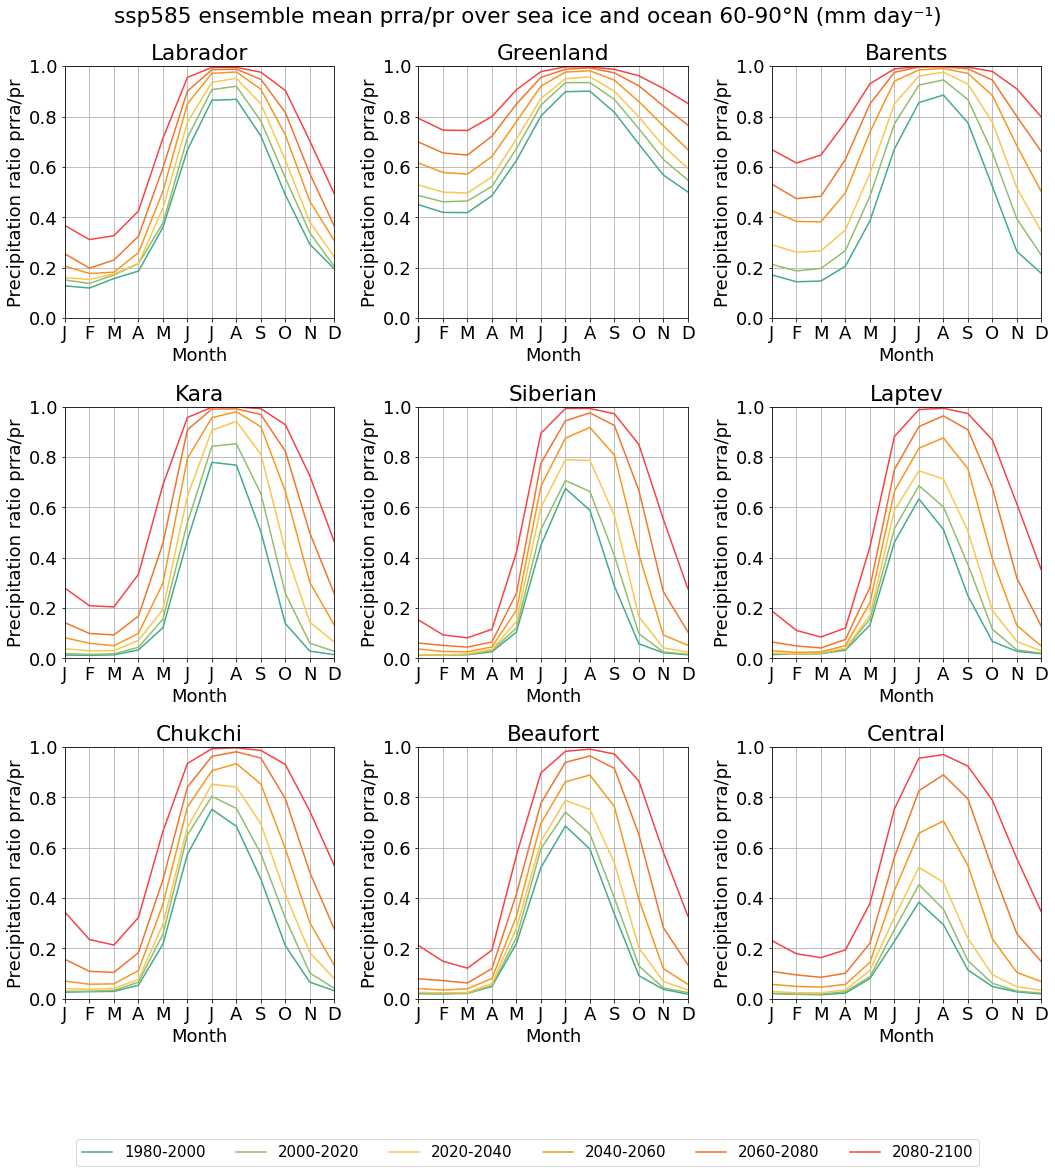

In [6]:
regions = libs.local.get_ensemble_regional_series('pr', experiment)
regions_prra = libs.local.get_ensemble_regional_series('prra', experiment)

# https://coolors.co/palette/f94144-f3722c-f8961e-f9c74f-90be6d-43aa8b-4d908e-277da1
time_slices_custom = [
    { 'slice': { 'time': slice('1980-01-01', '2001-01-01') }, 'label': '1980-2000', 'color': '#43aa8b' },
    { 'slice': { 'time': slice('2000-01-01', '2021-01-01') }, 'label': '2000-2020', 'color': '#90be6d' },
    { 'slice': { 'time': slice('2020-01-01', '2041-01-01') }, 'label': '2020-2040', 'color': '#f9c74f' },
    { 'slice': { 'time': slice('2040-01-01', '2061-01-01') }, 'label': '2040-2060', 'color': '#f8961e' },
    { 'slice': { 'time': slice('2060-01-01', '2081-01-01') }, 'label': '2060-2080', 'color': '#f3722c' },
    { 'slice': { 'time': slice('2080-01-01', '2101-01-01') }, 'label': '2080-2100', 'color': '#f94144' },
]

arr = []
for i, data in enumerate(regions):
    region_arr = []
    for s in time_slices_custom:
        s_label = s['label']
        data_prra = regions_prra[i].sel(**s['slice']).groupby('time.month').mean('time')
        data_pr = data.sel(**s['slice']).groupby('time.month').mean('time')
        data_pr_ratio = data_prra / data_pr
        data_pr_ratio.attrs = regions_prra[i].attrs
        data_pr_ratio['Ensemble mean'].attrs['color'] = s['color']
        data_pr_ratio['Ensemble mean'].attrs['label'] = s['label']
        region_arr.append(data_pr_ratio)

    arr.append(region_arr)

libs.plot.monthly_variability_regional(
    arr,
    legend_below=True,
    title=f'{experiment} ensemble mean prra/pr over sea ice and ocean 60-90°N ({time_series_units})',
    variables=['Ensemble mean'],
    ylabel='Precipitation ratio prra/pr',
    yrange=(0, 1)
)

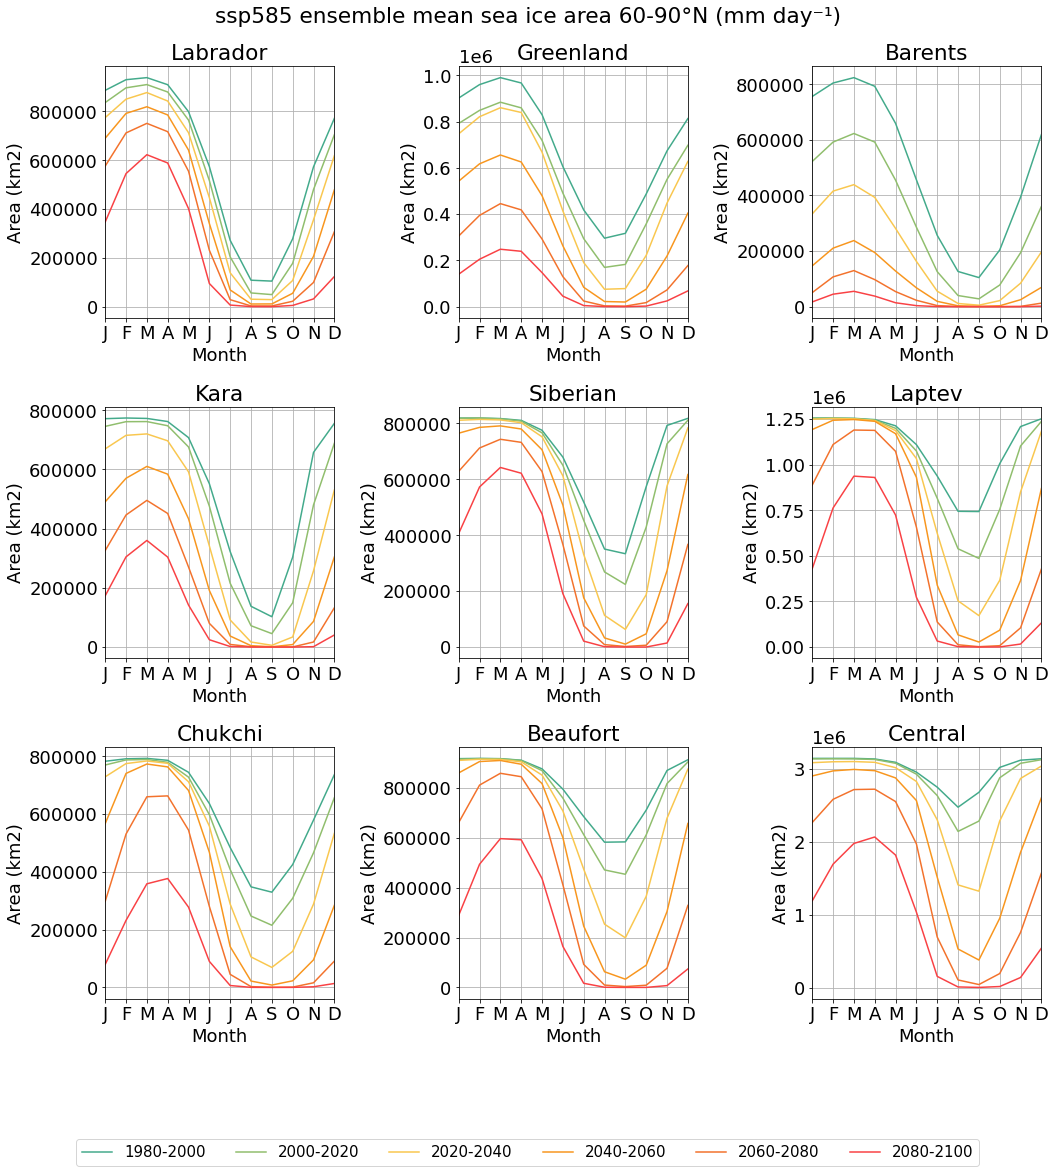

In [7]:
regions = libs.local.get_ensemble_regional_series('siconc', experiment)

# https://coolors.co/palette/f94144-f3722c-f8961e-f9c74f-90be6d-43aa8b-4d908e-277da1
time_slices_custom = [
    { 'slice': { 'time': slice('1980-01-01', '2001-01-01') }, 'label': '1980-2000', 'color': '#43aa8b' },
    { 'slice': { 'time': slice('2000-01-01', '2021-01-01') }, 'label': '2000-2020', 'color': '#90be6d' },
    { 'slice': { 'time': slice('2020-01-01', '2041-01-01') }, 'label': '2020-2040', 'color': '#f9c74f' },
    { 'slice': { 'time': slice('2040-01-01', '2061-01-01') }, 'label': '2040-2060', 'color': '#f8961e' },
    { 'slice': { 'time': slice('2060-01-01', '2081-01-01') }, 'label': '2060-2080', 'color': '#f3722c' },
    { 'slice': { 'time': slice('2080-01-01', '2101-01-01') }, 'label': '2080-2100', 'color': '#f94144' },
]

arr = []
for i, data in enumerate(regions):
    region_arr = []
    for s in time_slices_custom:
        s_label = s['label']
        data_slice = data.sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        region_arr.append(data_slice)

    arr.append(region_arr)

libs.plot.monthly_variability_regional(
    arr,
    legend_below=True,
    title=f'{experiment} ensemble mean sea ice area 60-90°N ({time_series_units})',
    variables=['Ensemble mean'],
    ylabel='Area (km2)',
    #yrange=(0, 1)
)

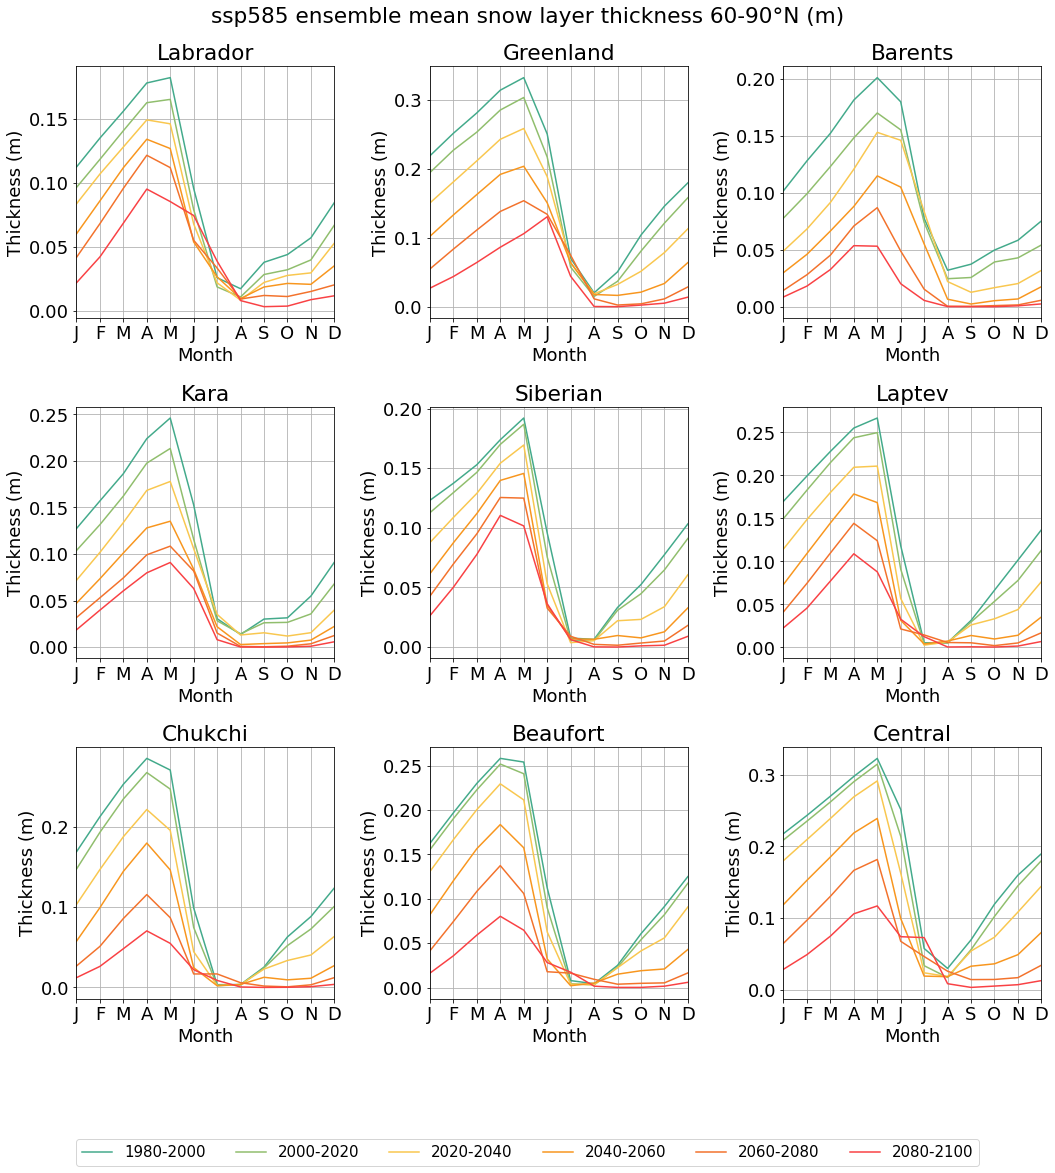

In [8]:
regions = libs.local.get_ensemble_regional_series('sisnthick', experiment)

# https://coolors.co/palette/f94144-f3722c-f8961e-f9c74f-90be6d-43aa8b-4d908e-277da1
time_slices_custom = [
    { 'slice': { 'time': slice('1980-01-01', '2001-01-01') }, 'label': '1980-2000', 'color': '#43aa8b' },
    { 'slice': { 'time': slice('2000-01-01', '2021-01-01') }, 'label': '2000-2020', 'color': '#90be6d' },
    { 'slice': { 'time': slice('2020-01-01', '2041-01-01') }, 'label': '2020-2040', 'color': '#f9c74f' },
    { 'slice': { 'time': slice('2040-01-01', '2061-01-01') }, 'label': '2040-2060', 'color': '#f8961e' },
    { 'slice': { 'time': slice('2060-01-01', '2081-01-01') }, 'label': '2060-2080', 'color': '#f3722c' },
    { 'slice': { 'time': slice('2080-01-01', '2101-01-01') }, 'label': '2080-2100', 'color': '#f94144' },
]

arr = []
for i, data in enumerate(regions):
    region_arr = []
    for s in time_slices_custom:
        s_label = s['label']
        data_slice = data.sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        region_arr.append(data_slice)

    arr.append(region_arr)

libs.plot.monthly_variability_regional(
    arr,
    legend_below=True,
    title=f'{experiment} ensemble mean snow layer thickness 60-90°N (m)',
    variables=['Ensemble mean'],
    ylabel='Thickness (m)',
    #yrange=(0, 1)
)

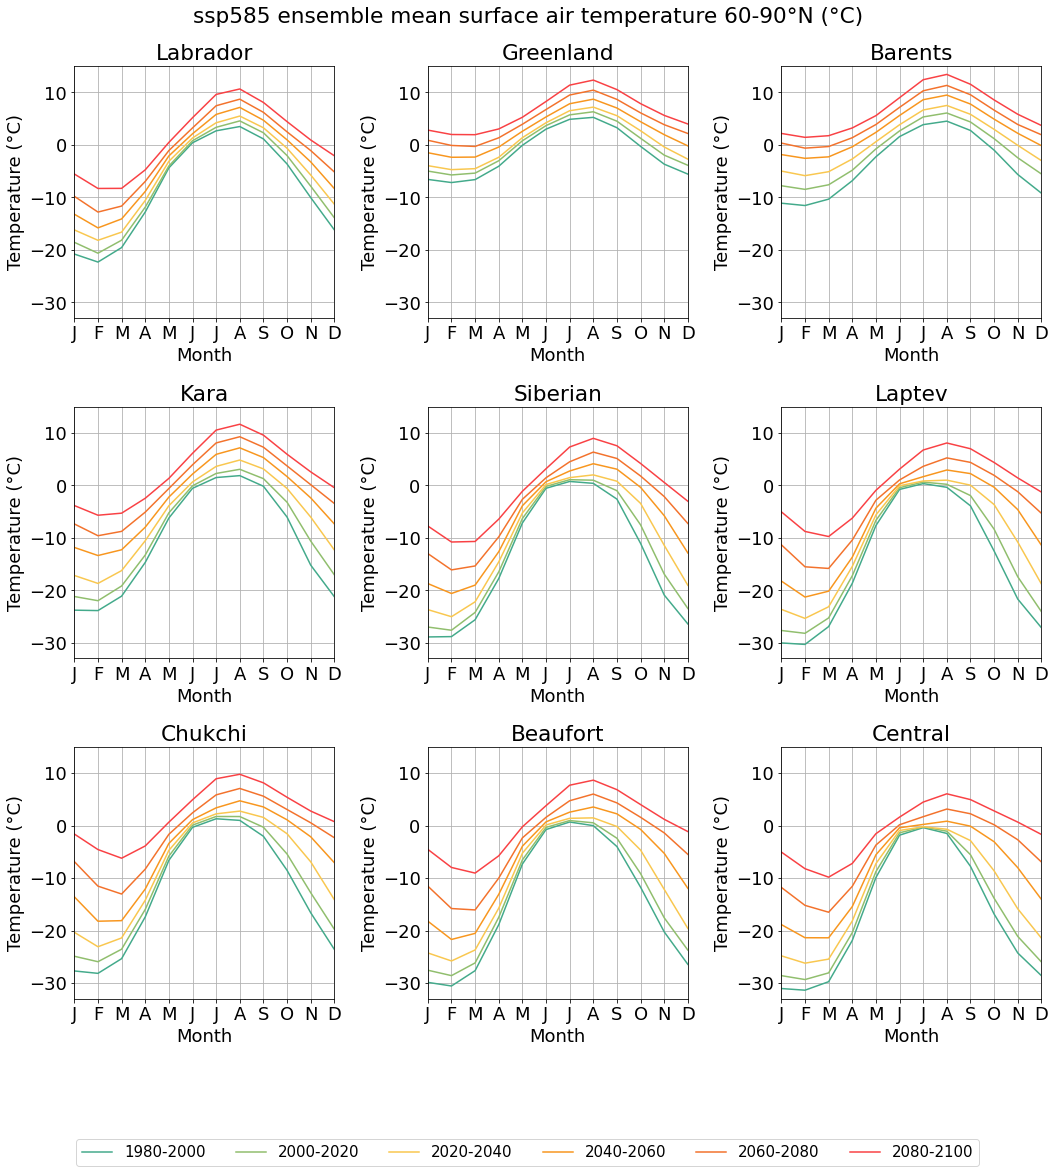

In [11]:
regions = libs.local.get_ensemble_regional_series('tas', experiment)

# https://coolors.co/palette/f94144-f3722c-f8961e-f9c74f-90be6d-43aa8b-4d908e-277da1
time_slices_custom = [
    { 'slice': { 'time': slice('1980-01-01', '2001-01-01') }, 'label': '1980-2000', 'color': '#43aa8b' },
    { 'slice': { 'time': slice('2000-01-01', '2021-01-01') }, 'label': '2000-2020', 'color': '#90be6d' },
    { 'slice': { 'time': slice('2020-01-01', '2041-01-01') }, 'label': '2020-2040', 'color': '#f9c74f' },
    { 'slice': { 'time': slice('2040-01-01', '2061-01-01') }, 'label': '2040-2060', 'color': '#f8961e' },
    { 'slice': { 'time': slice('2060-01-01', '2081-01-01') }, 'label': '2060-2080', 'color': '#f3722c' },
    { 'slice': { 'time': slice('2080-01-01', '2101-01-01') }, 'label': '2080-2100', 'color': '#f94144' },
]

arr = []
for i, data in enumerate(regions):
    region_arr = []
    for s in time_slices_custom:
        s_label = s['label']
        data_slice = data.sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        region_arr.append(data_slice)

    arr.append(region_arr)

libs.plot.monthly_variability_regional(
    arr,
    legend_below=True,
    title=f'{experiment} ensemble mean surface air temperature 60-90°N (°C)',
    variables=['Ensemble mean'],
    ylabel='Temperature (°C)',
    yrange=(-33, 15)
)

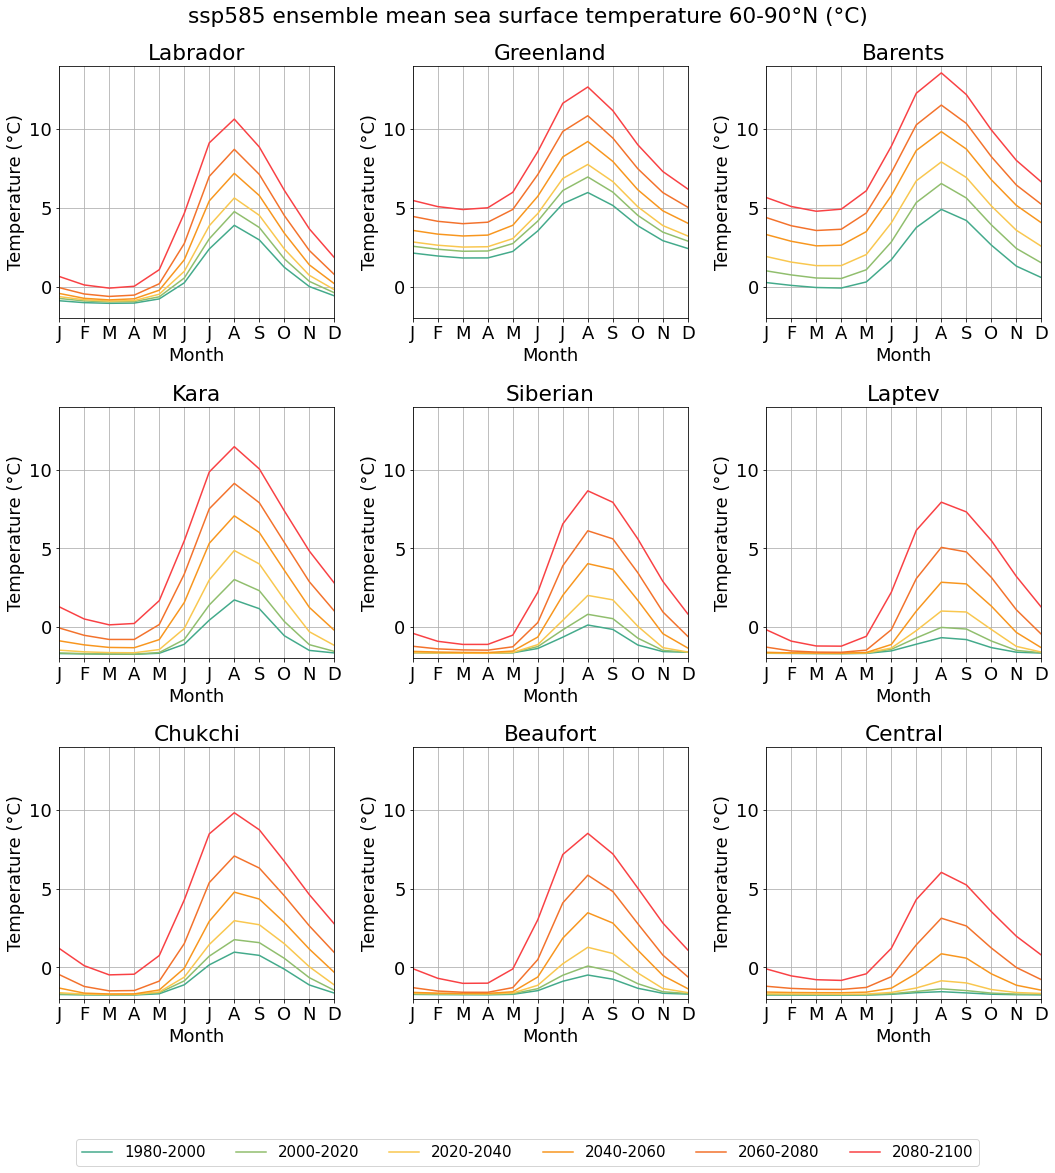

In [12]:
regions = libs.local.get_ensemble_regional_series('tos', experiment)

# https://coolors.co/palette/f94144-f3722c-f8961e-f9c74f-90be6d-43aa8b-4d908e-277da1
time_slices_custom = [
    { 'slice': { 'time': slice('1980-01-01', '2001-01-01') }, 'label': '1980-2000', 'color': '#43aa8b' },
    { 'slice': { 'time': slice('2000-01-01', '2021-01-01') }, 'label': '2000-2020', 'color': '#90be6d' },
    { 'slice': { 'time': slice('2020-01-01', '2041-01-01') }, 'label': '2020-2040', 'color': '#f9c74f' },
    { 'slice': { 'time': slice('2040-01-01', '2061-01-01') }, 'label': '2040-2060', 'color': '#f8961e' },
    { 'slice': { 'time': slice('2060-01-01', '2081-01-01') }, 'label': '2060-2080', 'color': '#f3722c' },
    { 'slice': { 'time': slice('2080-01-01', '2101-01-01') }, 'label': '2080-2100', 'color': '#f94144' },
]

arr = []
for i, data in enumerate(regions):
    region_arr = []
    for s in time_slices_custom:
        s_label = s['label']
        data_slice = data.sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        region_arr.append(data_slice)

    arr.append(region_arr)

libs.plot.monthly_variability_regional(
    arr,
    legend_below=True,
    title=f'{experiment} ensemble mean sea surface temperature 60-90°N (°C)',
    variables=['Ensemble mean'],
    ylabel='Temperature (°C)',
    yrange=(-2, 14)
)

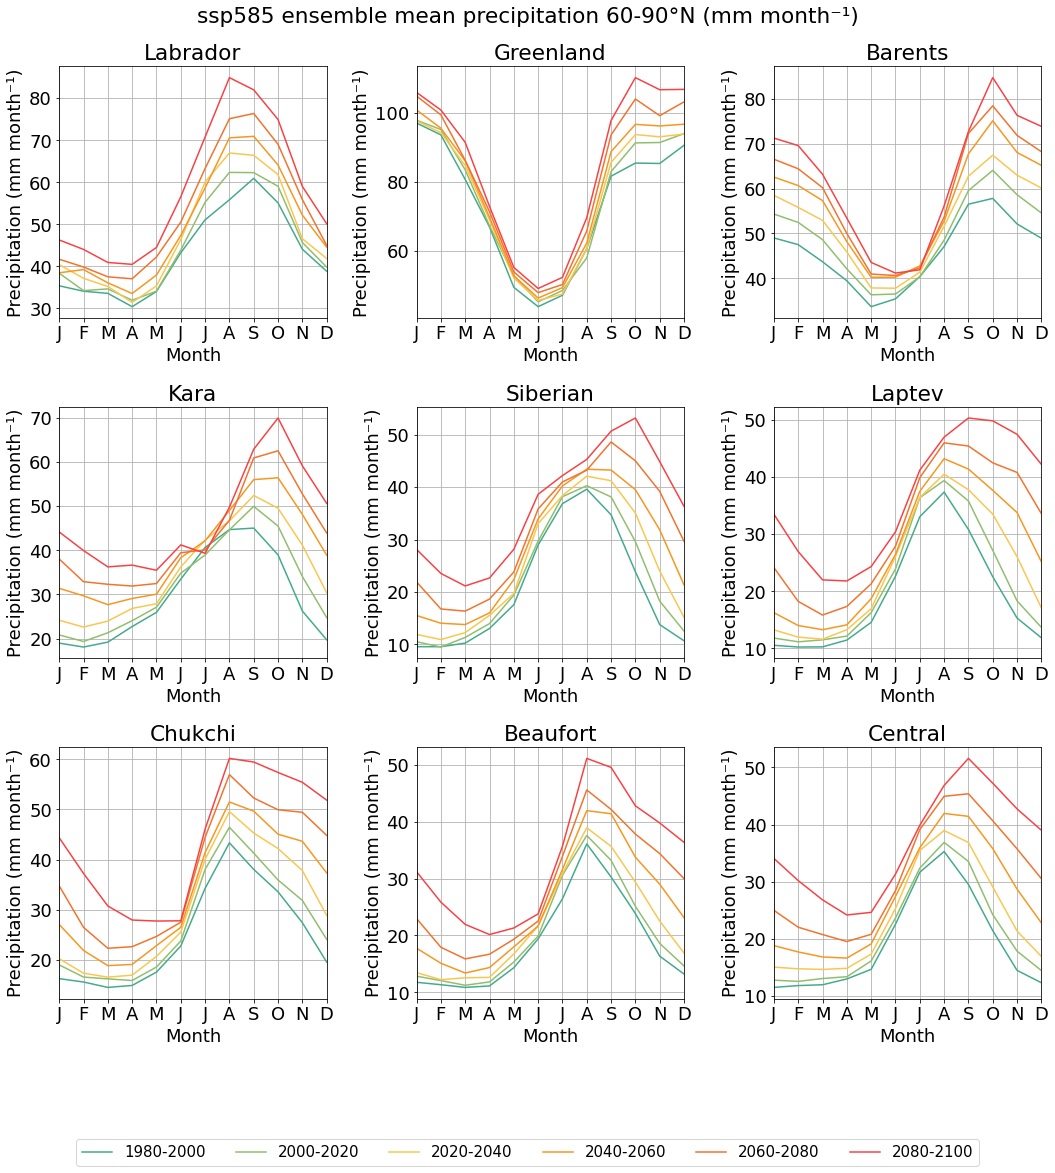

In [14]:
regions = libs.local.get_ensemble_regional_series('pr', experiment)

# https://coolors.co/palette/f94144-f3722c-f8961e-f9c74f-90be6d-43aa8b-4d908e-277da1
time_slices_custom = [
    { 'slice': { 'time': slice('1980-01-01', '2001-01-01') }, 'label': '1980-2000', 'color': '#43aa8b' },
    { 'slice': { 'time': slice('2000-01-01', '2021-01-01') }, 'label': '2000-2020', 'color': '#90be6d' },
    { 'slice': { 'time': slice('2020-01-01', '2041-01-01') }, 'label': '2020-2040', 'color': '#f9c74f' },
    { 'slice': { 'time': slice('2040-01-01', '2061-01-01') }, 'label': '2040-2060', 'color': '#f8961e' },
    { 'slice': { 'time': slice('2060-01-01', '2081-01-01') }, 'label': '2060-2080', 'color': '#f3722c' },
    { 'slice': { 'time': slice('2080-01-01', '2101-01-01') }, 'label': '2080-2100', 'color': '#f94144' },
]

arr = []
for i, data in enumerate(regions):
    region_arr = []
    for s in time_slices_custom:
        s_label = s['label']
        data_slice = (data * 30).sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        region_arr.append(data_slice)

    arr.append(region_arr)

libs.plot.monthly_variability_regional(
    arr,
    legend_below=True,
    title=f'{experiment} ensemble mean precipitation 60-90°N (mm month⁻¹)',
    variables=['Ensemble mean'],
    ylabel='Precipitation (mm month⁻¹)',
    #yrange=(-2, 14)
)

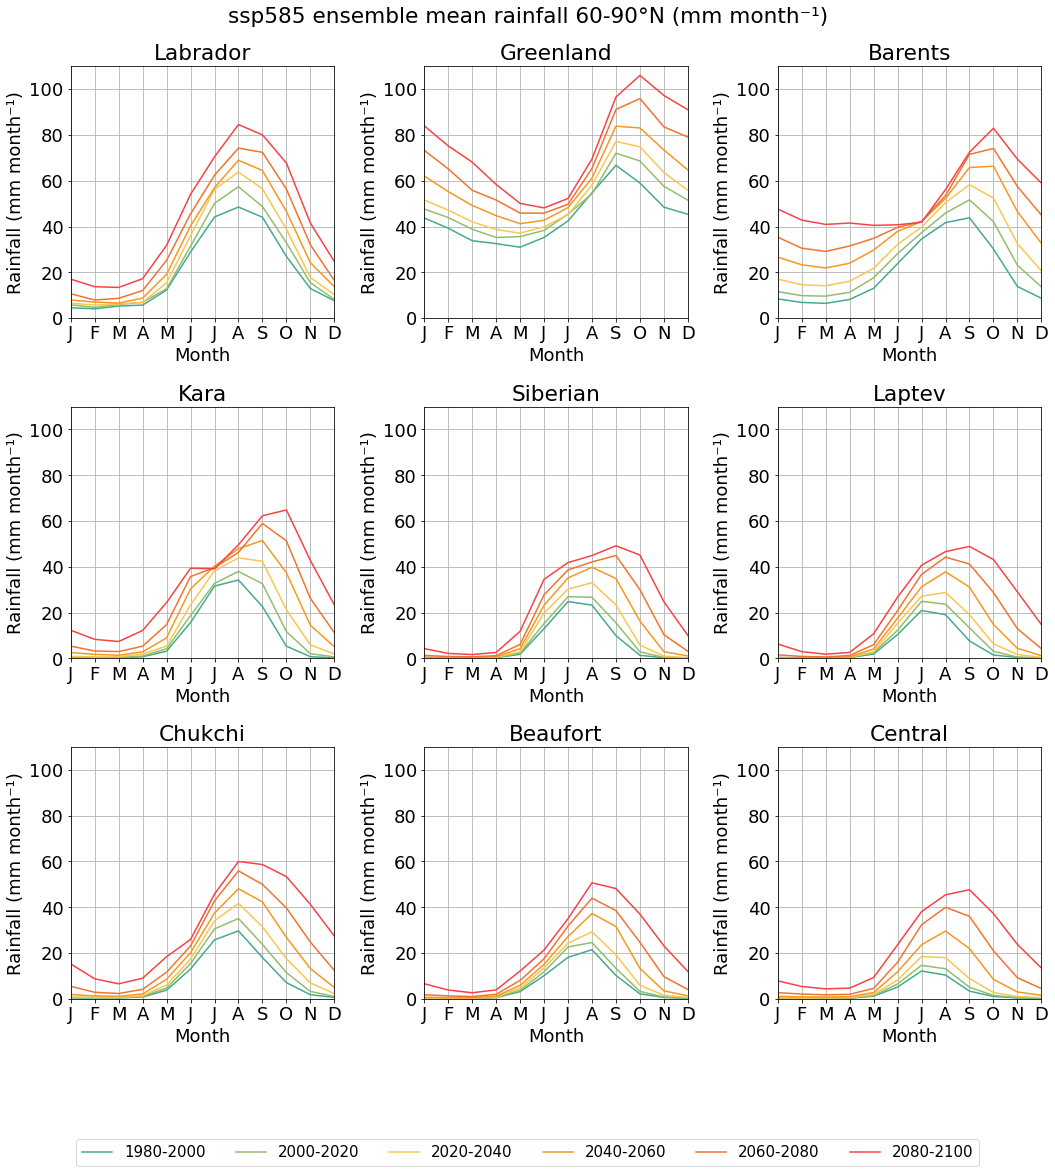

In [19]:
regions = libs.local.get_ensemble_regional_series('prra', experiment)

# https://coolors.co/palette/f94144-f3722c-f8961e-f9c74f-90be6d-43aa8b-4d908e-277da1
time_slices_custom = [
    { 'slice': { 'time': slice('1980-01-01', '2001-01-01') }, 'label': '1980-2000', 'color': '#43aa8b' },
    { 'slice': { 'time': slice('2000-01-01', '2021-01-01') }, 'label': '2000-2020', 'color': '#90be6d' },
    { 'slice': { 'time': slice('2020-01-01', '2041-01-01') }, 'label': '2020-2040', 'color': '#f9c74f' },
    { 'slice': { 'time': slice('2040-01-01', '2061-01-01') }, 'label': '2040-2060', 'color': '#f8961e' },
    { 'slice': { 'time': slice('2060-01-01', '2081-01-01') }, 'label': '2060-2080', 'color': '#f3722c' },
    { 'slice': { 'time': slice('2080-01-01', '2101-01-01') }, 'label': '2080-2100', 'color': '#f94144' },
]

arr = []
for i, data in enumerate(regions):
    region_arr = []
    for s in time_slices_custom:
        s_label = s['label']
        data_slice = (data * 30).sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        region_arr.append(data_slice)

    arr.append(region_arr)

libs.plot.monthly_variability_regional(
    arr,
    legend_below=True,
    title=f'{experiment} ensemble mean rainfall 60-90°N (mm month⁻¹)',
    variables=['Ensemble mean'],
    ylabel='Rainfall (mm month⁻¹)',
    yrange=(0, 110)
)

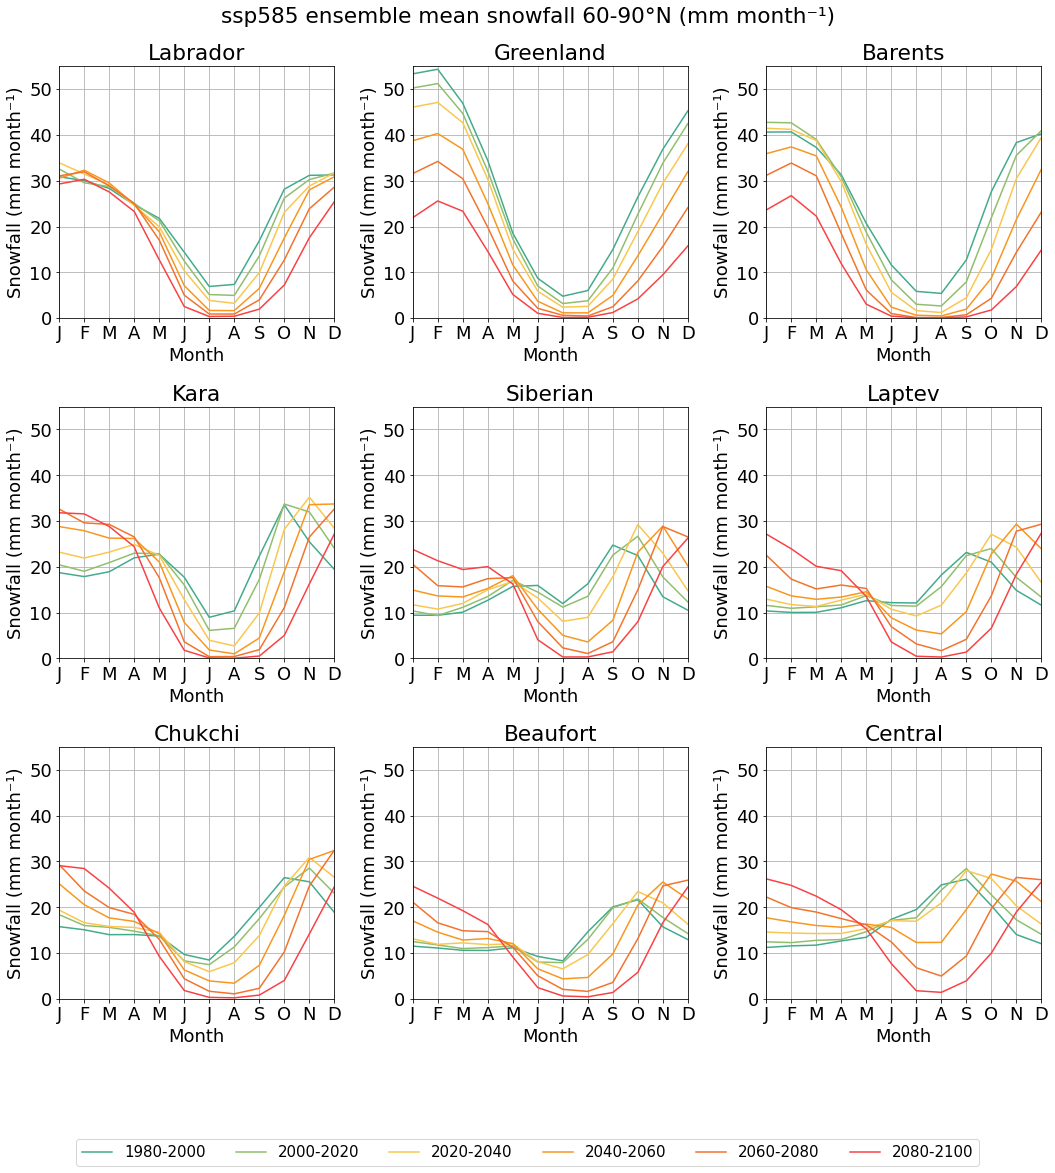

In [17]:
regions = libs.local.get_ensemble_regional_series('prsn', experiment)

# https://coolors.co/palette/f94144-f3722c-f8961e-f9c74f-90be6d-43aa8b-4d908e-277da1
time_slices_custom = [
    { 'slice': { 'time': slice('1980-01-01', '2001-01-01') }, 'label': '1980-2000', 'color': '#43aa8b' },
    { 'slice': { 'time': slice('2000-01-01', '2021-01-01') }, 'label': '2000-2020', 'color': '#90be6d' },
    { 'slice': { 'time': slice('2020-01-01', '2041-01-01') }, 'label': '2020-2040', 'color': '#f9c74f' },
    { 'slice': { 'time': slice('2040-01-01', '2061-01-01') }, 'label': '2040-2060', 'color': '#f8961e' },
    { 'slice': { 'time': slice('2060-01-01', '2081-01-01') }, 'label': '2060-2080', 'color': '#f3722c' },
    { 'slice': { 'time': slice('2080-01-01', '2101-01-01') }, 'label': '2080-2100', 'color': '#f94144' },
]

arr = []
for i, data in enumerate(regions):
    region_arr = []
    for s in time_slices_custom:
        s_label = s['label']
        data_slice = (data * 30).sel(**s['slice']).groupby('time.month').mean('time')
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        region_arr.append(data_slice)

    arr.append(region_arr)

libs.plot.monthly_variability_regional(
    arr,
    legend_below=True,
    title=f'{experiment} ensemble mean snowfall 60-90°N (mm month⁻¹)',
    variables=['Ensemble mean'],
    ylabel='Snowfall (mm month⁻¹)',
    yrange=(0, 55)
)